In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [27]:
normal_path = 'OralCancer/Normal'
oscc_path = 'OralCancer/OSCC'

In [28]:
def load_images(folder_path, label, image_size=(128, 128)):
    images, labels = [], []
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load Normal and OSCC images
normal_images, normal_labels = load_images(normal_path, label=0)
oscc_images, oscc_labels = load_images(oscc_path, label=1)

In [29]:
images = np.concatenate((normal_images, oscc_images), axis=0)
labels = np.concatenate((normal_labels, oscc_labels), axis=0)

In [30]:
# Normalize images
images = images / 255.0
# One-hot encode labels
labels = to_categorical(labels, num_classes=2)

In [31]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)

In [36]:
from tfkan.layers import DenseKAN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the KAN model
model = Sequential([
    Flatten(input_shape=(128, 128, 3)),  # Flatten the 3D image into 1D
    DenseKAN(64),
    Activation('relu'),  # Apply activation separately
    DenseKAN(32),
    Activation('relu'),  # Apply activation separately
    DenseKAN(2),
    Activation('softmax')  # Apply activation separately for output layer
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 49152)             0         
                                                                 
 dense_kan_18 (DenseKAN)     (None, 64)                28901440  
                                                                 
 activation_18 (Activation)  (None, 64)                0         
                                                                 
 dense_kan_19 (DenseKAN)     (None, 32)                19232     
                                                                 
 activation_19 (Activation)  (None, 32)                0         
                                                                 
 dense_kan_20 (DenseKAN)     (None, 2)                 962       
                                                                 
 activation_20 (Activation)  (None, 2)                

In [37]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('kan_oral_cancer_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
109/109 [==============================] - 70s 626ms/step - loss: 1.2021 - accuracy: 0.5488 - val_loss: 0.7120 - val_accuracy: 0.5443
Epoch 2/50
109/109 [==============================] - 67s 618ms/step - loss: 0.6667 - accuracy: 0.6343 - val_loss: 0.6107 - val_accuracy: 0.6600
Epoch 3/50
109/109 [==============================] - 67s 613ms/step - loss: 0.7159 - accuracy: 0.6184 - val_loss: 0.8770 - val_accuracy: 0.5070
Epoch 4/50
109/109 [==============================] - 66s 604ms/step - loss: 0.6728 - accuracy: 0.6300 - val_loss: 0.6215 - val_accuracy: 0.6559
Epoch 5/50
109/109 [==============================] - 65s 600ms/step - loss: 0.6777 - accuracy: 0.6395 - val_loss: 0.6811 - val_accuracy: 0.5674
Epoch 6/50
109/109 [==============================] - 65s 601ms/step - loss: 0.6120 - accuracy: 0.6661 - val_loss: 0.7094 - val_accuracy: 0.5473
Epoch 7/50
109/109 [==============================] - 66s 608ms/step - loss: 0.6174 - accuracy: 0.6655 - val_loss: 1.0367 - val_ac

In [38]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


16/16 [==============================] - 4s 258ms/step - loss: 0.6550 - accuracy: 0.6633
Test Loss: 0.6549516320228577
Test Accuracy: 0.6632652878761292


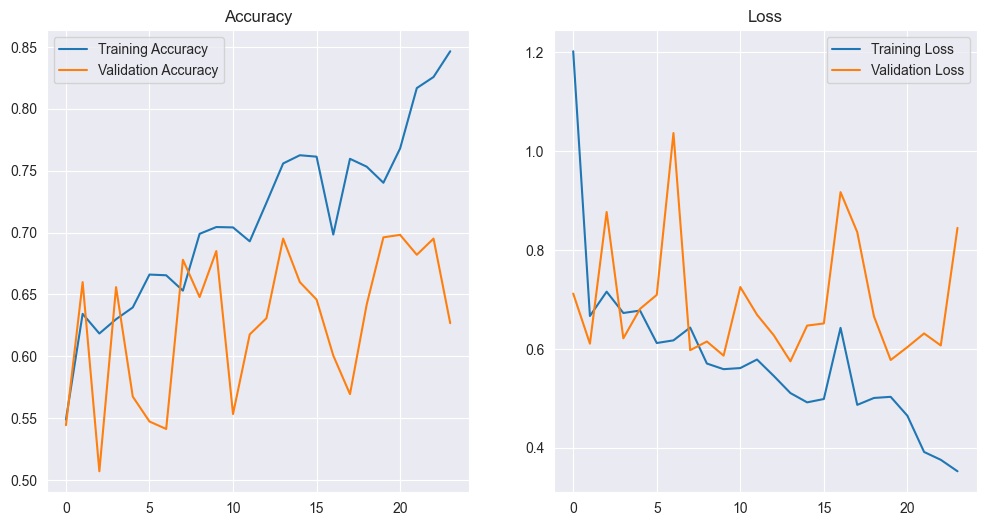

16/16 [==============================] - 5s 264ms/step


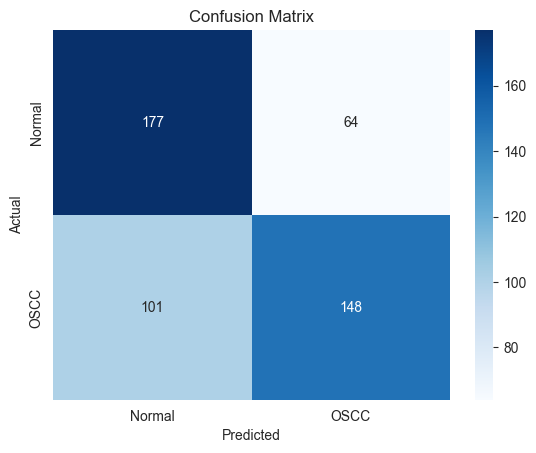

In [39]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'OSCC']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
